In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import spit.colocalize as coloc 
import spit.visualize as viz
from glob import glob
import scipy.stats as st
from IPython.display import clear_output

In [3]:
# let's simulate 100 trajectories
# in box 10x10u
# D = 1 um^2/s
# Interact with probability 0.95 within 25nM
# dissociate with probability 0.1 per time step
# dt = 1ms
# acq_t = 50ms

In [26]:
class Particle():
    '''particle object with diffusion'''
    def __init__(self, ID, D, pos, bounds=(0, 10)):
        self.posx = [pos[0]]
        self.posy = [pos[1]]
        self.position = np.array([self.posx[-1], self.posy[-1]])
        self.D = D
        self.bounds = bounds
        self.ID = ID
        self.state = 'monomer'
        self.partner = None
        
    def update(self, stepx, stepy, dt = 0.001):
        new_posx = self.posx[-1] + stepx
        new_posy = self.posy[-1] + stepy

        if not (self.bounds[0] <= new_posx < self.bounds[1]):
            new_posx = self.posx[-1] - stepx
        if not (self.bounds[0] <= new_posy < self.bounds[1]):
            new_posy = self.posy[-1] - stepy

        self.posx.append(new_posx)
        self.posy.append(new_posy)
        self.position = np.array([self.posx[-1], self.posy[-1]])


# initialize dictionary with particles
pdict = {}
for ID in range(3):
    x, y = np.random.uniform(0, 10, size=2)
    pdict[ID] = Particle(ID, 1, (x, y))

# initialize parameters
l = 0.5
k1 = 0.5
k2 = 0.1

# update one step
for t in range(100):

    # check if there are any colocalizations and change their state to dimer
    for particle1 in pdict.values():
        for particle2 in pdict.values():
            if particle1.ID == particle2.ID:
                continue
            if np.linalg.norm(particle1.position - particle2.position) < 0.5:
                print(particle1.ID, particle2.ID)

    for particle in pdict.values():
        stepx, stepy = np.random.normal(0, np.sqrt(2*particle.D*0.05), size=2)
        particle.update(stepx, stepy, 0.05)

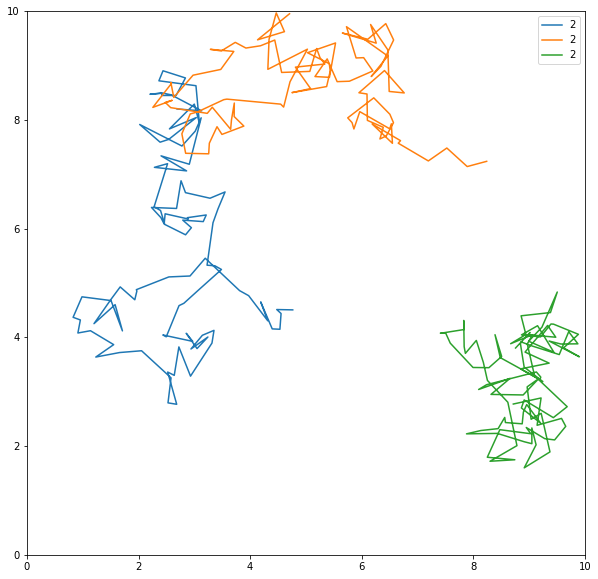

In [27]:
plt.figure(figsize=[10,10])
for particle in pdict.values():
    plt.plot(particle.posx, particle.posy, label=ID)
plt.legend()
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()